In [25]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 데이터 가져오기
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

In [26]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [29]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [27]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [28]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

<br><br><br><br><br><br>

# 1. 데이터 분석

## 1-1. 결측값 확인

In [5]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1-2. id 중복체크

In [6]:
# id_duplicated = train[train.duplicated(['id'])]
print(len(train['id']))
print(len(pd.value_counts(train['id'])))

15035
15035


## 1-3. bathrooms 화장실 개수

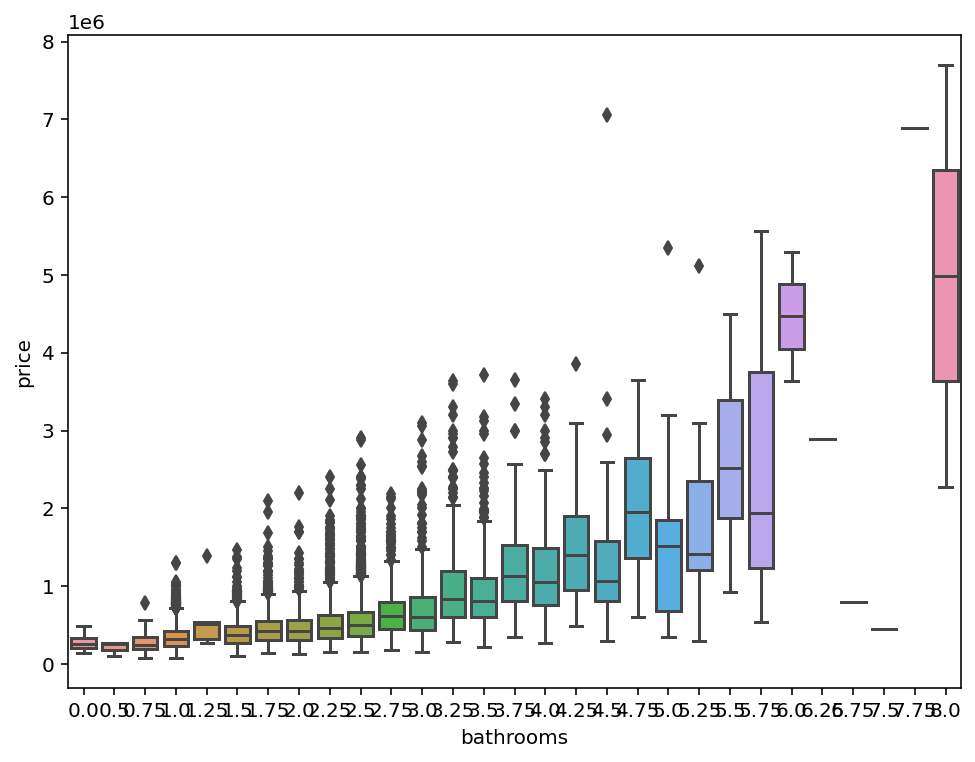

In [7]:
bathrooms_data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bathrooms', y='price', data = bathrooms_data)

## 1-4. grade 집의 등급
- grade가 높을수록 price도 증가하고 있다.  
- min과 max를 벗어난 이상치가 확인되고 있다.

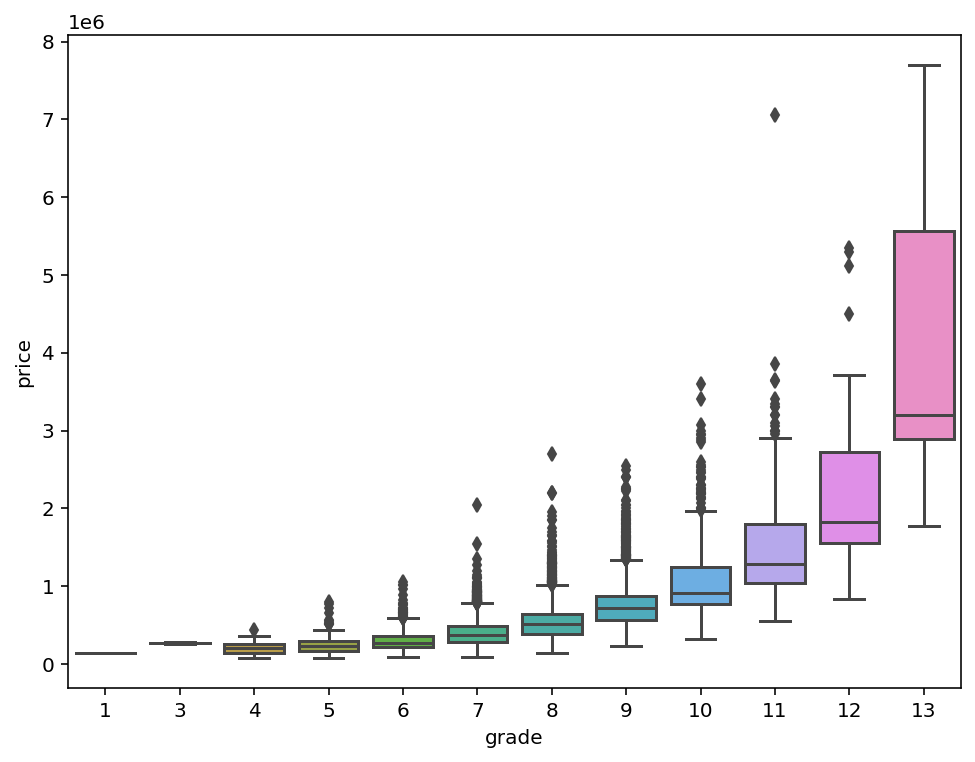

In [8]:
price_grade_data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data = price_grade_data)

## 1-5. sqft_living 주거공간의 크기
- 전체적으로 크기가 커지면 가격이 오르는 것을 볼 수 있다.
- 하지만 14000일때 가격이 비교적 아래에 있는 것을 보아 이상치로 확인된다.

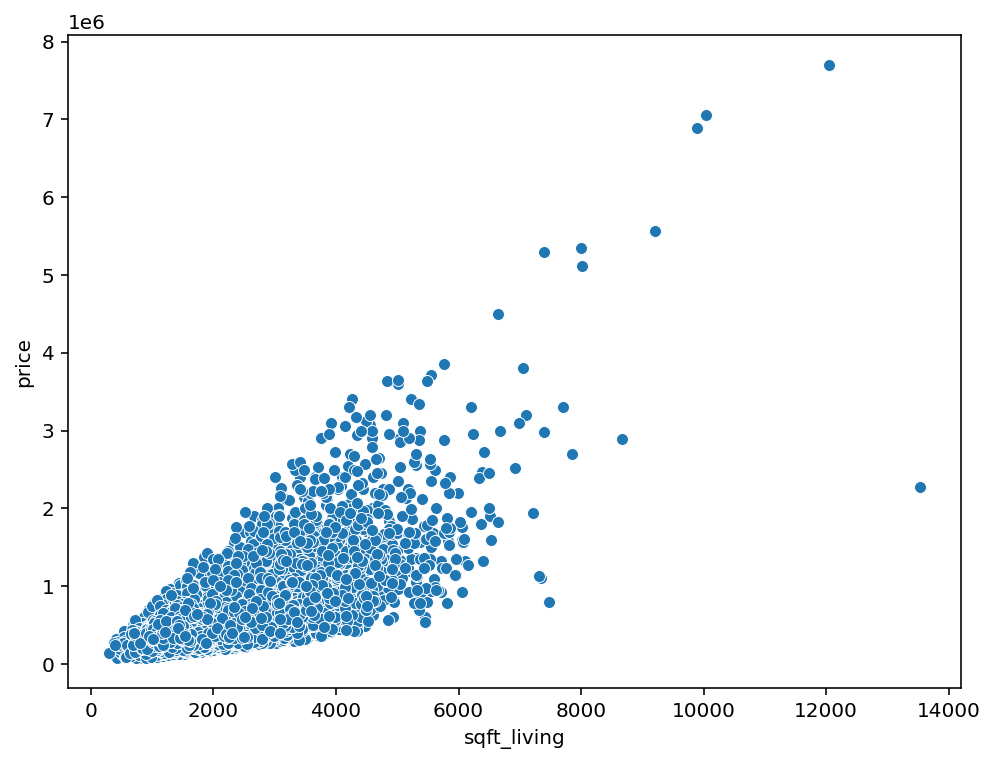

In [9]:
price_sqftliving_data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living', y='price', data = price_sqftliving_data)

## 1-6. sqft_above 지하실을 제외한 평방피트

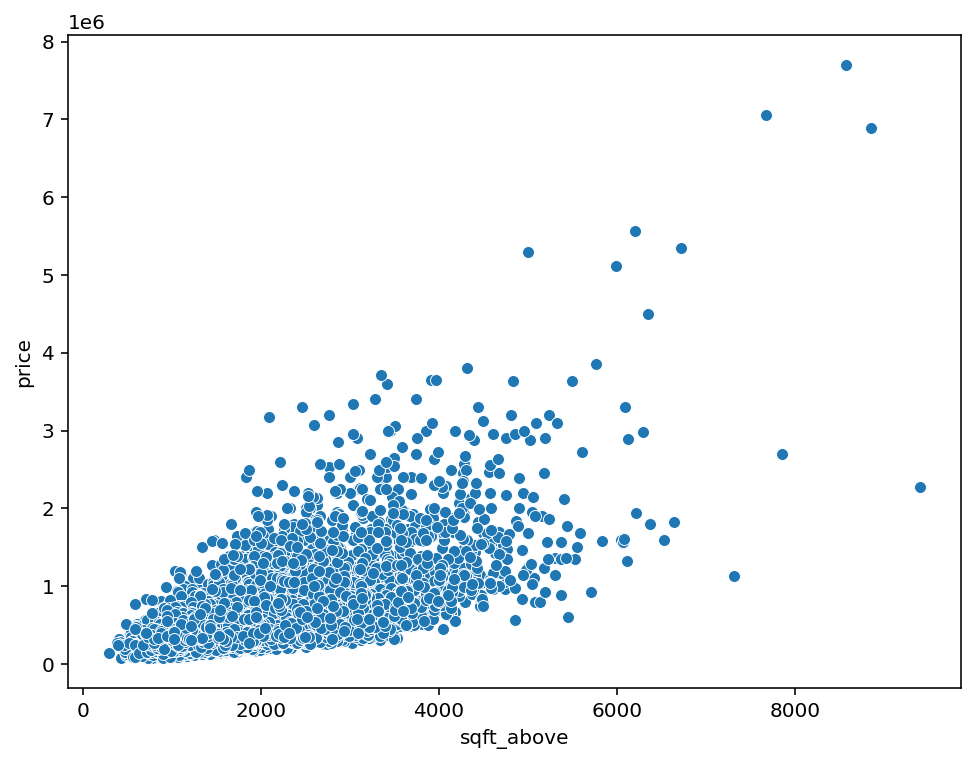

In [10]:
price_sqft_above_data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_above', y='price', data = price_sqft_above_data)

## 1-7. lat 위도
- 위도 47.5 ~ 47.8에 위치하는 집이 가격이 높은 것을 볼 수 있다.

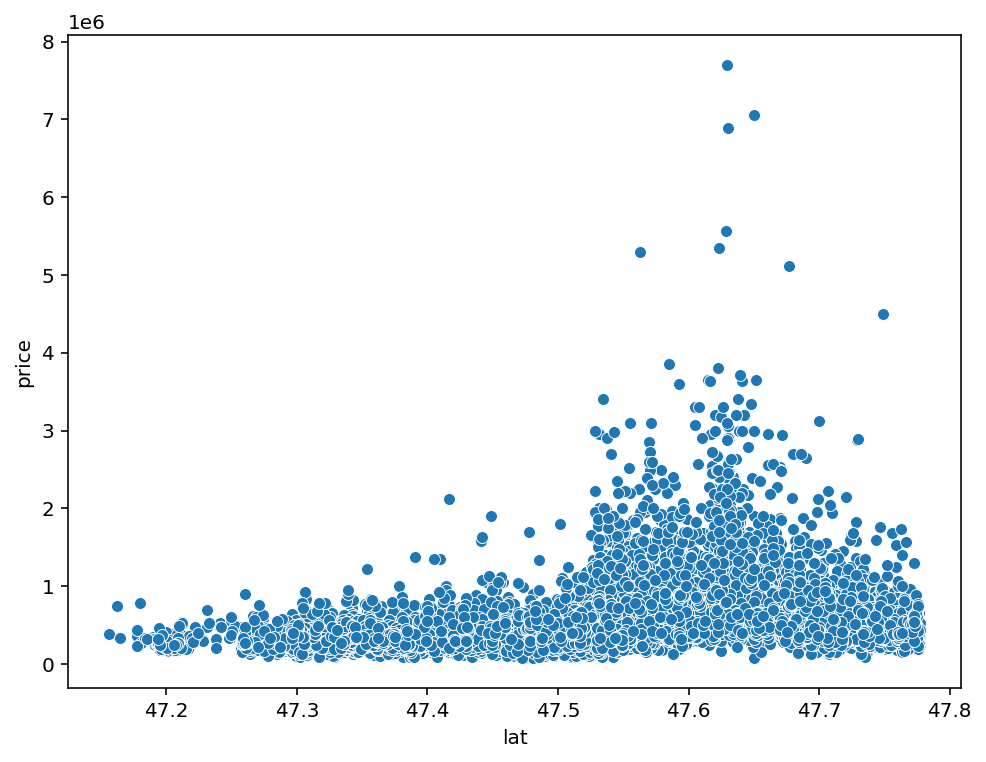

In [11]:
price_lat_data = pd.concat([train['price'], train['lat']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='lat', y='price', data = price_lat_data)

<br><br><br><br><br><br>

# 2. 데이터 전처리

## 2-1. date 형태 변환
before : 20141013T000000  
after : 20141013

In [12]:
train['date'] = train['date'].apply(lambda i: i[:8]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2-2 이상치 제거 - sqft_living

In [13]:
train.loc[train['sqft_living']>13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [14]:
train = train.loc[train['sqft_living'] < 13000]

## 2-3. id 컬럼 삭제

In [15]:
del train['id']
del test['id']

## 2-2. 타겟 데이터인 price컬럼 분리

In [16]:
y = train['price']
del train['price']

## 가격 데이터 분포도 확인

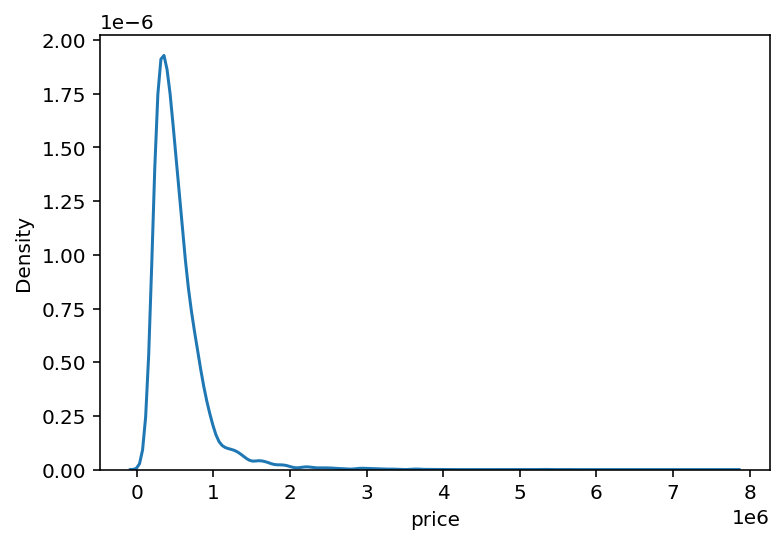

In [17]:
# seaborn의 kdeplot을 활용해 y의 분포 확인
sns.kdeplot(y)
plt.show()

## 라벨 y - 정규분포형태로 변환
- np.log1p(y) : 로그함수로 변환  
- np.expm1(y) : 각 원소x마다 exp(x)-1을 반환  

우선 로그변환을 해준 후 모델이 값을 예측한 후에 다시 np.expm1()을 통해 되돌림

In [18]:
y = np.log1p(y)
y.head()

0    12.309987
1    12.100718
2    13.142168
3    12.458779
4    12.583999
Name: price, dtype: float64

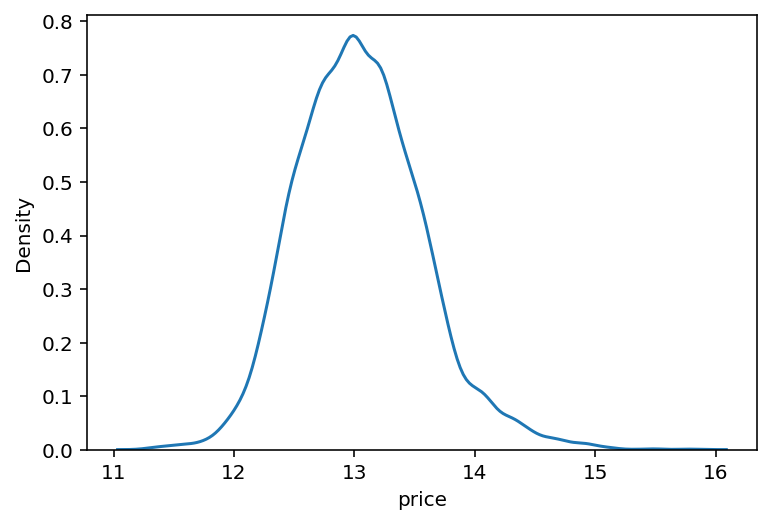

In [19]:
sns.kdeplot(y)
plt.show()

## 자료형 확인
모두 실수 or 정수자료형이므로 모델 학습 활용 가능

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15034 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15034 non-null  int64  
 1   bedrooms       15034 non-null  int64  
 2   bathrooms      15034 non-null  float64
 3   sqft_living    15034 non-null  int64  
 4   sqft_lot       15034 non-null  int64  
 5   floors         15034 non-null  float64
 6   waterfront     15034 non-null  int64  
 7   view           15034 non-null  int64  
 8   condition      15034 non-null  int64  
 9   grade          15034 non-null  int64  
 10  sqft_above     15034 non-null  int64  
 11  sqft_basement  15034 non-null  int64  
 12  yr_built       15034 non-null  int64  
 13  yr_renovated   15034 non-null  int64  
 14  zipcode        15034 non-null  int64  
 15  lat            15034 non-null  float64
 16  long           15034 non-null  float64
 17  sqft_living15  15034 non-null  int64  
 18  sqft_l

# RMSE

In [21]:
# 기존에 y를 로그함수로 변환해주었기 때문에 mean_squared_error에 값을 넘기기 전,
# np.expm1으로 다시 변환해서 넘겨준다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# Model
- random_state
  - 모델 초기화나 데이터셋 구성에 사용되는 랜덤 시드값
  - 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택
  - None일 때, 파라미터 초기화나 데이터셋 구성 양상이 달라져 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라진다.
  - 어떤 시도가 모델 성능향상에 긍정적이였는지 판단하기 위해 랜덤적 요소의 변화때문에 생기는 불확실성을 제거해야 한다.
  - 따라서 특정값으로 고정시켜준다.

In [22]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 모델별 학습 및 예측

In [24]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        # 예측결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,127760.299471
RandomForestRegressor,125386.279800
LGBMRegressor,111336.855007
XGBRegressor,110757.710531


# GridSearchCV 사용 (Grid Search)
- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [54]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
grid_model = GridSearchCV(model, 
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1,
                          n_jobs=5)
grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.2s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [55]:
grid_model.cv_results_

{'mean_fit_time': array([0.07197905, 0.06846633, 0.12015281, 0.20280371]),
 'std_fit_time': array([0.00634186, 0.00231538, 0.0073537 , 0.01725118]),
 'mean_score_time': array([0.00434022, 0.00631104, 0.00818834, 0.01472282]),
 'std_score_time': array([0.00061894, 0.00024945, 0.00051153, 0.00202723]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [57]:
params = grid_model.cv_results_['params']         # 각 파라미터에 대한 조합
score = grid_model.cv_results_['mean_test_score'] # 각 조합에 대한 점수

results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


- 각 파라미터에 대한 조합마다의 점수를 나타냄
- 왜 음수일까?  
  - scoring : 'neg_mean_squared_error'
  - neg_mean_squared_error : 평균 제곱 오차의 반댓값(음수)을 계산
  - 점수가 올라가면 좋다! (즉, 돈을 적게 잃어야 하는 것과 같다)

In [59]:
 # rmse: 평균제곱근오차
results['RMSE'] = np.sqrt(-1*results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [61]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [62]:
# `RMSLE`가 낮은 순서대로 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [64]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

# 그리드 탐색해보기

In [65]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.2s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


# 위에 나온 결과로 학습 및 예측 결과 생성

위에서 max_depth = 10, n_estimators=100이 가장 좋은 조합으로 나왔다.

In [68]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)  # 원래 스케일로 되돌림
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

# csv에 쓰기

In [72]:
def save_submission(model, train, y, test, model_name, rmsle):
    # 위에 나온 결과로 학습 및 예측 결과 생성
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
    # csv에 쓰기
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [73]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/home/ssac14/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!
